In [1]:
import beatmap as bt
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, fixed, widgets, Button
from IPython.display import HTML, Javascript, display

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide raw code"></form>''')

### To run this notebook go to the `Kernel` tab in the tool bar and select `Restart & Run All`

# BEaTmap
Brunauer–Emmett–Teller (BET) theory describes the physical adsorption of a gas or vapour onto a solid surface. It can be thought of as an extension of the Langmuir adsorption isotherm to multilayer adsoption, where each layer of adsorbed molecules is described by the Langmuir equation. BET theory is commonly used to determine the specific surface area of porous materials [1](#references). 

$$\frac{1}{n(\frac{P}{Po} -1)}=\frac{C-1}{n_m C}\frac{P}{Po}+\frac{1}{n_m C}$$
<br>
<center>A linear form of the BET Equation</center>



Analysis of adsorption isotherms by BET theory is easily done, but can provide misleading answers. A paper by Roquerol et al describes five criteria that can be used to determine which relative pressure ranges of an isotherm follow the assumptions of BET Theory [2](#references).

**BEaTmap** (**B**runauer **E**mmett **a**nd **T**eller heat**map**) has been developed as a visualization tool, allowing the user to quickly and easily get a graphical representation of how BET theory applies to an experimental adsoption isotherm and provide a more rigorous specific surface area answer.

This notebook is an implementation of BEaTmap. First isotherm data must be imported in the form of a .csv file with the first column being relative pressure values and the second being specific amount of adsorbed molecules in mol per gram. Adsortbate-adsorbent information provided by the user is for reference and naming any .png or .csv files. Cross sectional area of the adsorbate must be provided in square Angstrom per molecule.

In [2]:
isotherm_data = bt.io.import_data()
bet_results = bt.core.bet(isotherm_data.iso_df, isotherm_data.a_o, isotherm_data.info)

Enter file name/path:vulcan_etoh.csv
Enter adsorbate-adsorbent information (this will be incorporated into file names):vulcan and etoh
Enter cross sectional area of adsorbate in square Angstrom:34.3

Adsorbate used has an adsorbed cross sectional area of 34.30 sq. Angstrom.

Isotherm data quality appears good.
Adsorbed molar amounts are increasing as relative pressure increases.
Isotherm is type II.


## Experimental Data

()

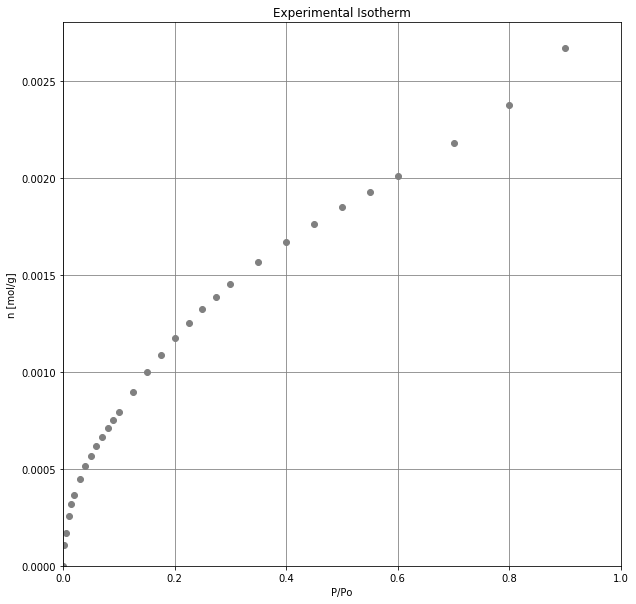

In [3]:
bt.vis.experimental_data_plot(isotherm_data, save_file=False)

## Validity Checks
The buttons below may be used to select which checks are applied to the BET results.

>Check 1: $n (P_o - P)$ must increase as relative pressure inceases.

>Check 2: positive y-intercept of BET equation (ie positive BET constant, C).

>Check 3: the monolayer adsorbed amount, nm, must fall within the range of adsorbed amounts of the relative pressure interval.

>Check 4: n is set to nm in the BET equation, and the equation is solved for relative pressure. This realtive pressure is then compared to the experimentalrelative pressure corresopnding to monolayer completion and must agree within 10%.

>Check 5: the minimum number of data points required for a relative pressure range to be considered valid.

In [4]:
mask_picker = interactive(bt.core.rouq_mask, intercept=fixed(bet_results.intercept), iso_df=fixed(bet_results.iso_df),
            nm=fixed(bet_results.nm), slope=fixed(bet_results.slope), check1=True, check2=True, check3=True, check4=True,
            check5=True, points = (2,len(bet_results.iso_df)))
display(mask_picker)

interactive(children=(Checkbox(value=True, description='check1'), Checkbox(value=True, description='check2'), …

>Select the criteria for a final specific surface area answer, minimum error or maximum data points:

In [5]:
selection = widgets.RadioButtons(
    options=['error', 'points'],
    value='error', 
    disabled=False
)

display(selection)

RadioButtons(options=('error', 'points'), value='error')

In [6]:
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))    
    
button = widgets.Button(description="Update checks")
button.on_click(run_all)
display(button)

Button(description='Update checks', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
specsa_answer = bt.core.ssa_answer(bet_results, mask_picker.result, criterion=selection.value)

The specific surface area value, based on error is 253.66 m2/g.


## Specific Surface Area
The specific surface area values that result from BET analysis can be visulaized as a heatmap, where every cell represents a relative pressure range. 

The gradient of each cell corresponds to the specific surface area of that relative pressure range.

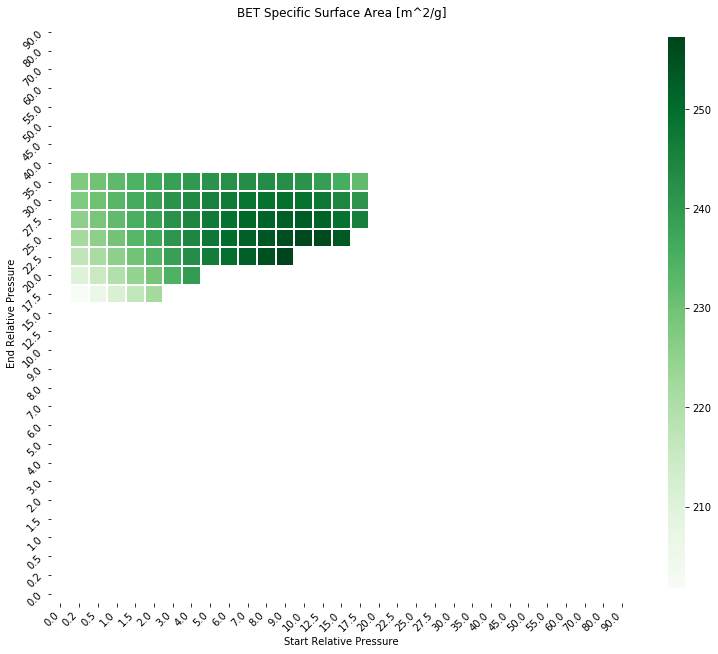

In [43]:
bt.vis.ssa_heatmap(bet_results, mask_picker.result, save_file = False)

## Error
Average percent error between the experimental data points and theoretical isotherm can also be visualized with a heatmap, and is done so below.

$$error = \frac{100\%}{m}\sum_{i=1}^{m} \frac{(n_{th} - n)}{n_{th}}, \quad m = \text{number of points in relative pressure range}$$

A lower error indicates better agreement between experimental data and the BET equation over the realtive pressure range.

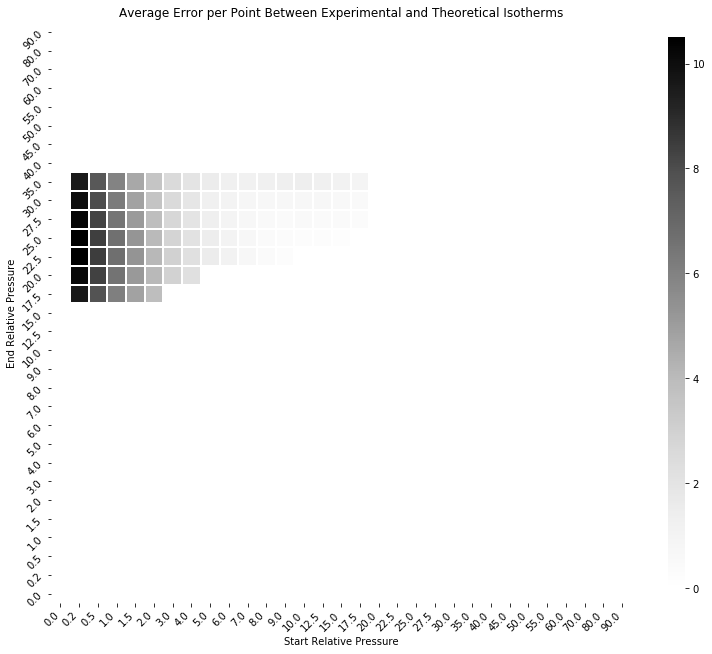

In [44]:
bt.vis.err_heatmap(bet_results, mask_picker.result, save_file = False)

## Comparison Plot
Comparing the BET Plots of the relative pressure ranges with the highest and lowest error shows that, while multiple valid relative pressure ranges may be valid, there can still be signifigant variance.  

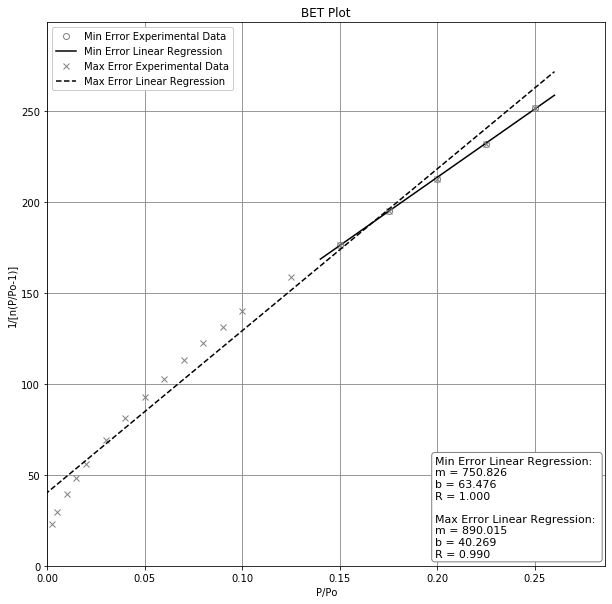

In [45]:
bt.vis.bet_combo_plot(bet_results, mask_picker.result, save_file = False)

## Isotherm Combination Plot

The bet_iso_combo_plot function creates a plot that shows the experimental isotherm superimposed on the theoretical isotherms for the relative pressure ranges with the lowest and highest error.

One can quickly get an idea of where in the relative pressure range the monolayer amount, nm, has been adsorbed by looking for where n/nm = 1.

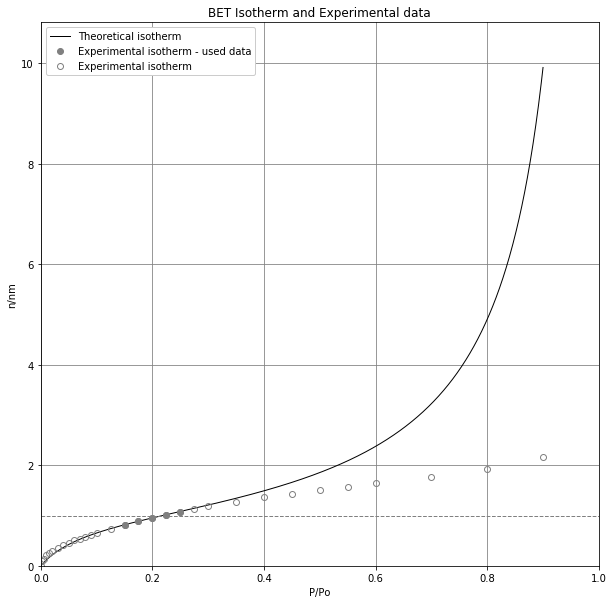

In [46]:
bt.vis.iso_combo_plot(bet_results, mask_picker.result, save_file = False)

## Summary Tables

In [47]:
ssa_table, c_table, ssa_std, c_std = bt.vis.dataframe_tables(bet_results, mask_picker.result)
display(HTML(ssa_table.to_html(index=False)))
print('Standard deviation of the specific surface area = %.3f' % (ssa_std))
display(HTML(c_table.to_html(index=False)))
print('Standard deviation of BET constant (C) = %.3f' % (c_std))

,Spec SA m2/g,C,Start P/Po,End P/Po
Min Spec SA,201.764,28.798,0.003,0.175
Max Spec SA,257.226,12.174,0.09,0.225
Mean Spec SA,238.308,n/a,n/a,n/a
Median Spec SA,241.068,n/a,n/a,n/a


Standard deviation of the specific surface area = 12.369


,C,Spec SA,Start P/Po,End P/Po,Error
Min C,12.174,257.226,0.09,0.225,0.29
Max C,28.798,201.764,0.003,0.175,9.605
Mean C,16.901,n/a,n/a,n/a,n/a
Median C,15.707,n/a,n/a,n/a,n/a
Min Error C,12.828,253.658,0.15,0.25,0.232
Max Error C,23.102,222.034,0.003,0.25,10.502


Standard deviation of BET constant (C) = 3.746


## Data Export
If you would like to write the data or results of BET analysis to .csv files, use the buttons below. 

The points slider may be used to select the minimum number of points for a valid relative pressure range.

Files will be created in the same directory as this notebook.

In [48]:
def export_data(points = 5, Raw_data = False, Processed_data = False):
        
    if Raw_data == True:
        bt.io.export_raw_data(bet_results)
        
    if Processed_data == True:
        bt.io.export_processed_data(bet_results, points)
        
    return()

export_data_buttons = interactive(export_data, points = (2,len(bet_results.iso_df),1), Raw_data = False, Processed_data = False)
export_data_buttons

interactive(children=(IntSlider(value=5, description='points', max=31, min=2), Checkbox(value=False, descripti…

<a id='references'></a>
## References
1. S. J. Gregg und K. S. W. Sing: Adsorption, Surface Area and Porosity 2nd ed. Academic Press, London, New York 1982.

2. Rouquerol, J., P. Llewellyn, and F. Rouquerol. "Is the BET equation applicable to microporous adsorbents." Stud. Surf. Sci. Catal 160.07 (2007): 49-56.